In [1]:
!pip install xgboost


In [2]:

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

from google.colab import files


import warnings
warnings.filterwarnings("ignore")


In [3]:
train = pd.read_csv("train.csv", parse_dates=["Date"])
test = pd.read_csv("test.csv", parse_dates=["Date"])
features = pd.read_csv("features.csv", parse_dates=["Date"])
stores = pd.read_csv("stores.csv")
train = train.merge(stores, on="Store", how="left").merge(features, on=["Store", "Date", "IsHoliday"], how="left")
test = test.merge(stores, on="Store", how="left").merge(features, on=["Store", "Date", "IsHoliday"], how="left")
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [4]:
def add_date_parts(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Is_Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    return df

train = add_date_parts(train)
test = add_date_parts(test)
train['Type'] = train['Type'].astype('category').cat.codes
test['Type'] = test['Type'].astype('category').cat.codes
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb


features_cols = ['Store', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                 'IsHoliday', 'Day', 'Month', 'Year', 'DayOfWeek', 'Is_Weekend']

X = train[features_cols]
y = train['Weekly_Sales']


X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=0.2)

model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)
print(f" Mean Absolute Error: {mae:.2f}")


 Mean Absolute Error: 11986.55


In [7]:

test_preds = model.predict(test[features_cols])
test['Weekly_Sales'] = test_preds

submission = test[['Store', 'Date', 'Weekly_Sales']]
submission['Id'] = submission['Store'].astype(str) + "_" + submission['Date'].dt.strftime('%Y-%m-%d')
submission = submission[['Id', 'Weekly_Sales']]

submission.to_csv("submission.csv", index=False)

from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

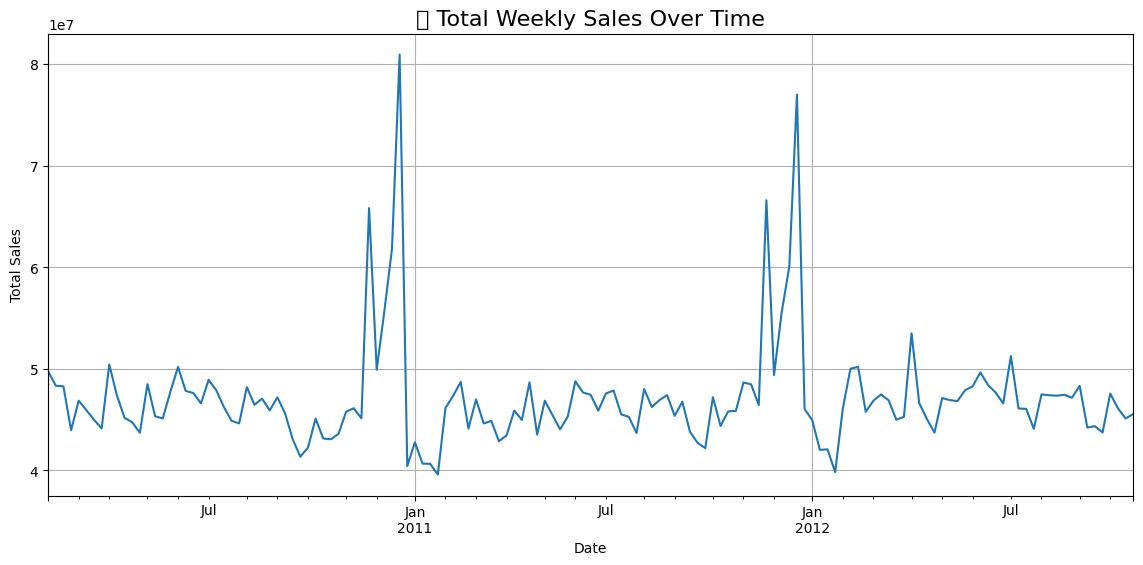

In [8]:
plt.figure(figsize=(14, 6))
train.groupby('Date')['Weekly_Sales'].sum().plot()
plt.title("🛍️ Total Weekly Sales Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()


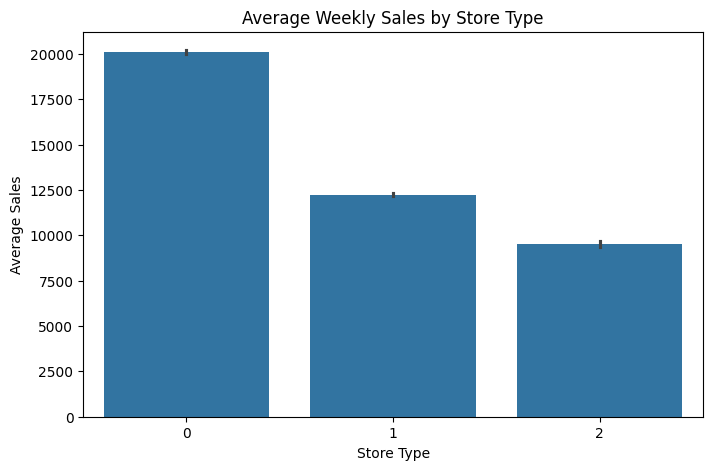

In [9]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Type', y='Weekly_Sales', data=train)
plt.title("Average Weekly Sales by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Average Sales")
plt.show()


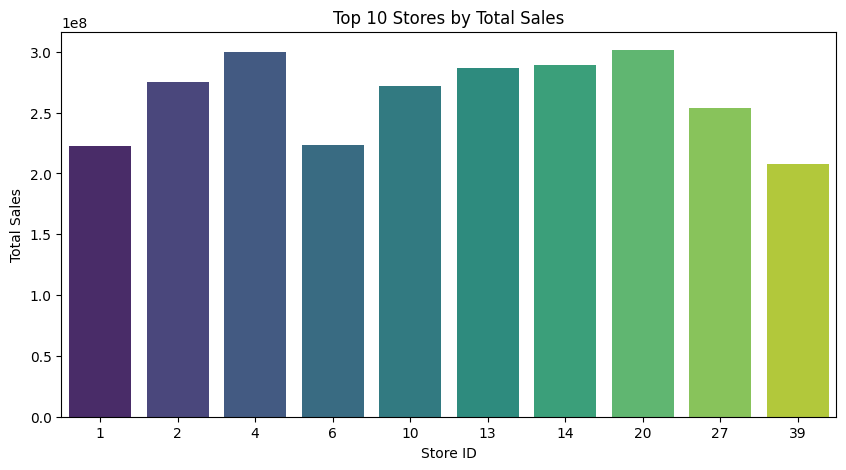

In [10]:
top_stores = train.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_stores.index, y=top_stores.values, palette='viridis')
plt.title("Top 10 Stores by Total Sales")
plt.xlabel("Store ID")
plt.ylabel("Total Sales")
plt.show()


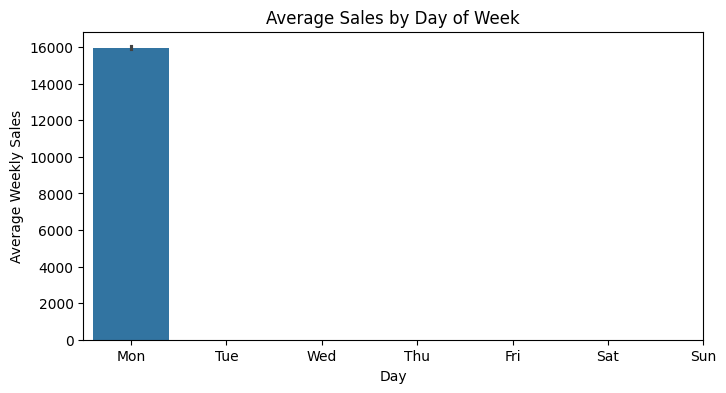

In [11]:
train['DayOfWeek'] = train['Date'].dt.dayofweek
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(8, 4))
sns.barplot(x=train['DayOfWeek'], y=train['Weekly_Sales'])
plt.xticks(ticks=range(7), labels=day_names)
plt.title("Average Sales by Day of Week")
plt.ylabel("Average Weekly Sales")
plt.xlabel("Day")
plt.show()


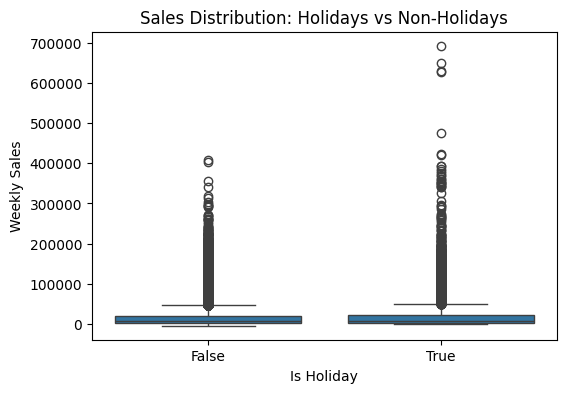

In [12]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='IsHoliday', y='Weekly_Sales', data=train)
plt.title("Sales Distribution: Holidays vs Non-Holidays")
plt.xlabel("Is Holiday")
plt.ylabel("Weekly Sales")
plt.show()



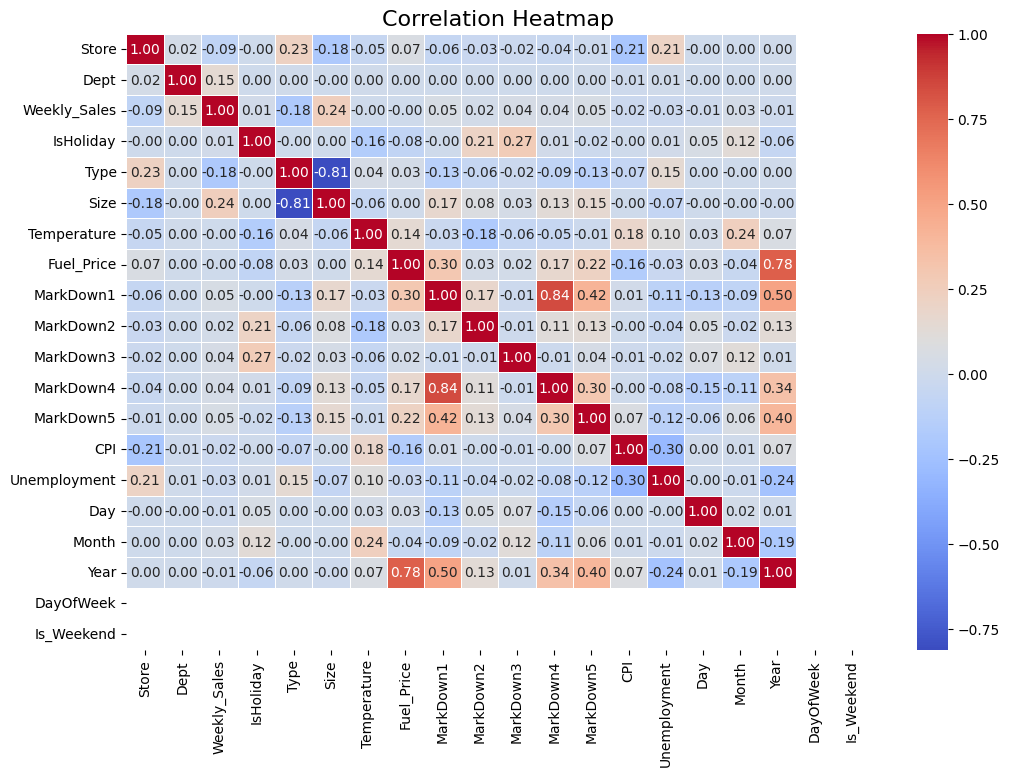

In [13]:
plt.figure(figsize=(12, 8))
corr = train.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()


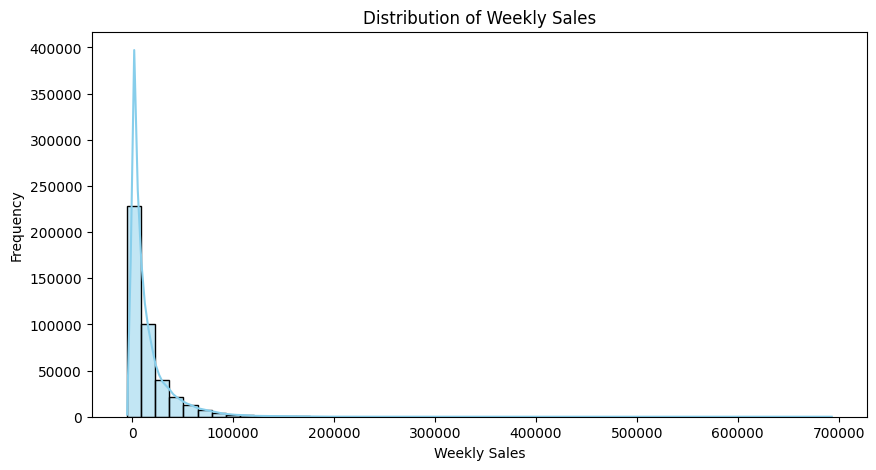

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(train['Weekly_Sales'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Weekly Sales")
plt.xlabel("Weekly Sales")
plt.ylabel("Frequency")
plt.show()


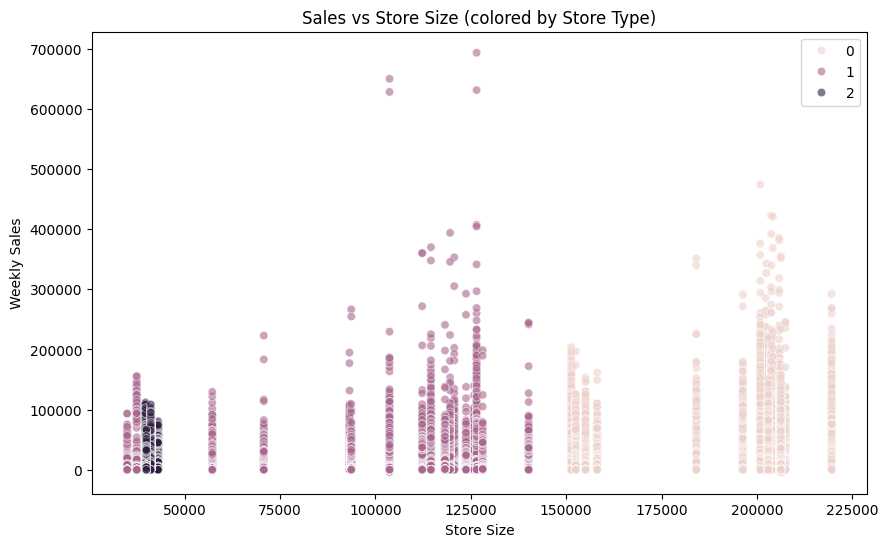

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Size', y='Weekly_Sales', data=train, hue='Type', alpha=0.6)
plt.title("Sales vs Store Size (colored by Store Type)")
plt.xlabel("Store Size")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()


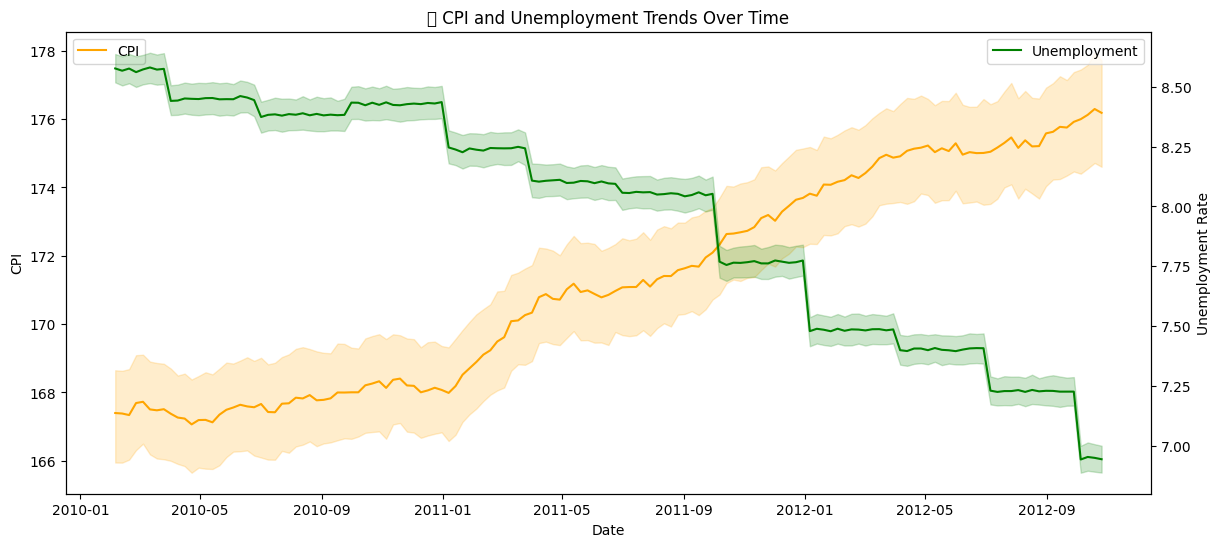

In [16]:
fig, ax1 = plt.subplots(figsize=(14,6))

sns.lineplot(data=train, x='Date', y='CPI', ax=ax1, label='CPI', color='orange')
ax1.set_ylabel('CPI')

ax2 = ax1.twinx()
sns.lineplot(data=train, x='Date', y='Unemployment', ax=ax2, label='Unemployment', color='green')
ax2.set_ylabel('Unemployment Rate')

plt.title("📉 CPI and Unemployment Trends Over Time")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()
